In [1]:
import pandas as pd
from pandas import json_normalize
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_json('result.json')

In [3]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [4]:
df_messages = json_normalize(df['messages'])
messages =  df_messages[df_messages['type'] == 'message']


In [5]:
messages = messages.copy()

In [6]:
messages = messages.rename(columns={'from': 'person'})
messages['date'] = pd.to_datetime(messages['date'])

In [7]:

people_sorted = sorted(messages['person'].dropna().unique())

user_map = {
    name: f'User_{i}'
    for i, name in enumerate(people_sorted, start=1)
}


messages['person'] = messages['person'].map(user_map)


In [8]:
per_person_sum = messages['person'].value_counts()

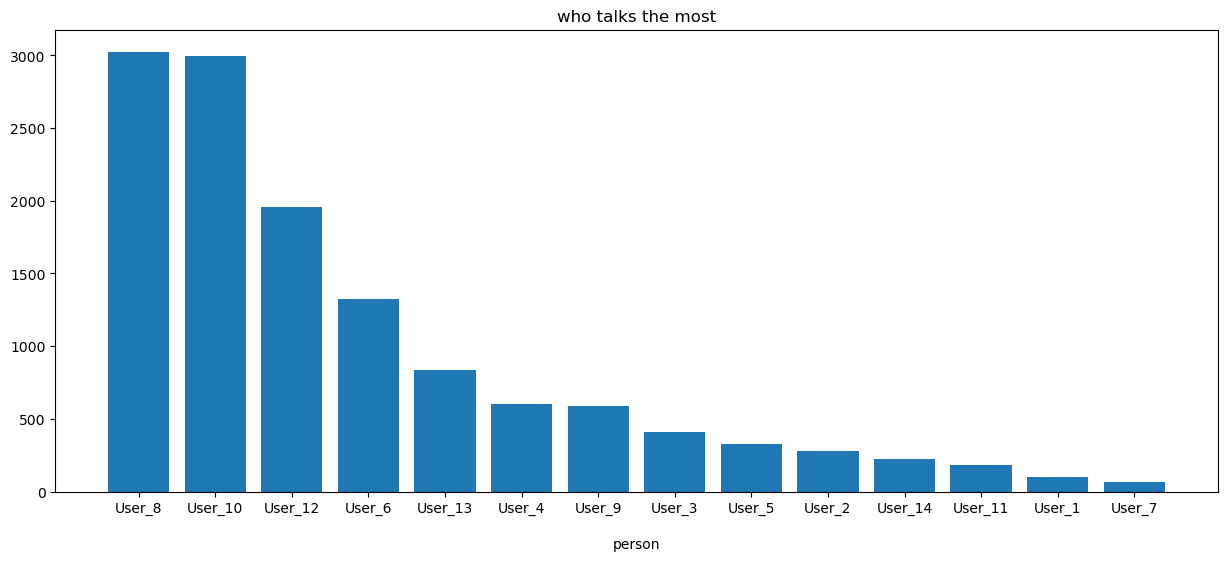

In [9]:
plt.figure(figsize=(15,6))
bars = plt.bar(x=per_person_sum.index, height=per_person_sum)
plt.xlabel('\nperson')
plt.title('who talks the most')
plt.show()

In [10]:
date_groups = messages.groupby(by = [messages['date'].dt.date, messages['person']]).agg(count=('person','count'))
date_groups = date_groups.reset_index()
date_groups = date_groups.sort_values(['person','date'])
date_groups['cumulative_person'] = date_groups.groupby('person')['count'].cumsum()

In [11]:
group1 = date_groups[date_groups['person'].isin(per_person_sum.head(7).index)]
group2 = date_groups[~date_groups['person'].isin(per_person_sum.head(7).index)]

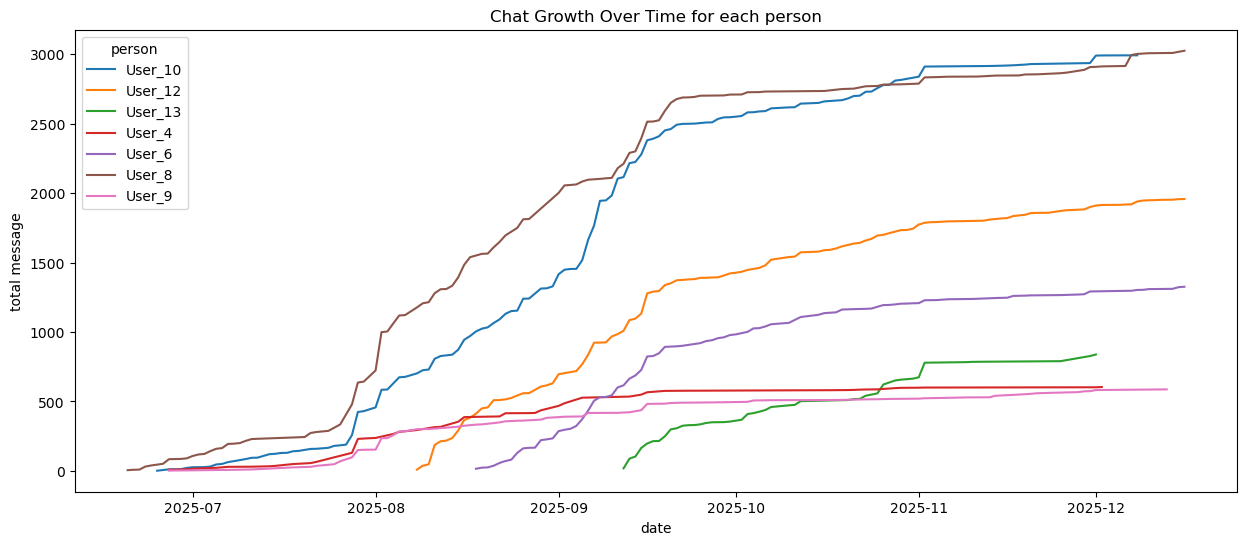

In [12]:
plt.figure(figsize=(15,6))
sns.lineplot(data=group1, x=group1['date'], y=group1['cumulative_person'], hue=group1['person'])
plt.ylabel('total message')
plt.title('Chat Growth Over Time for each person')
plt.show()

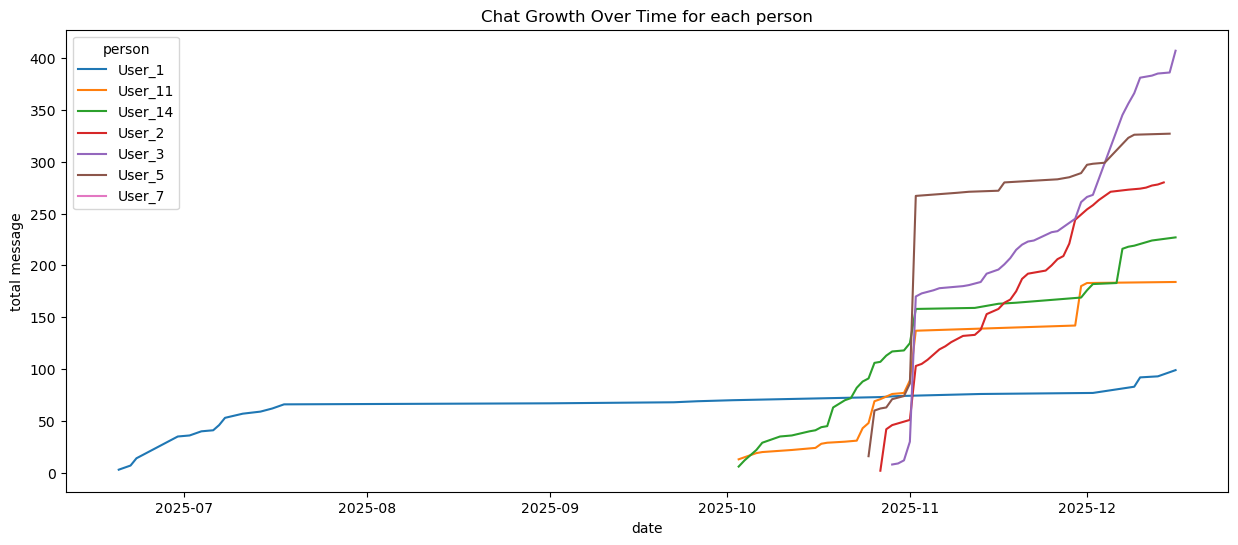

In [13]:
plt.figure(figsize=(15,6))
sns.lineplot(data=group2, x=group2['date'], y=group2['cumulative_person'], hue=group2['person'])
plt.ylabel('total message')
plt.title('Chat Growth Over Time for each person')
plt.show()

In [14]:
messages = messages.merge(messages[['id','person']], how='left', left_on='reply_to_message_id', right_on='id', suffixes=('', '_replied'))

In [15]:
replied_per_person = messages['person_replied'].value_counts()
replied_per_person = pd.DataFrame(replied_per_person)
per_person_sum = pd.DataFrame(per_person_sum)
replied_per_person = replied_per_person.merge(right=per_person_sum, how='inner',left_index=True,right_on='person', suffixes=('','_add'))

In [16]:
replied_per_person['percentage'] = round((replied_per_person['count'] / replied_per_person['count_add']) * 100, 1)
replied_per_person['ignored'] = 100 - replied_per_person['percentage']

In [17]:
replied_per_person = replied_per_person.sort_values('ignored', ascending=False)

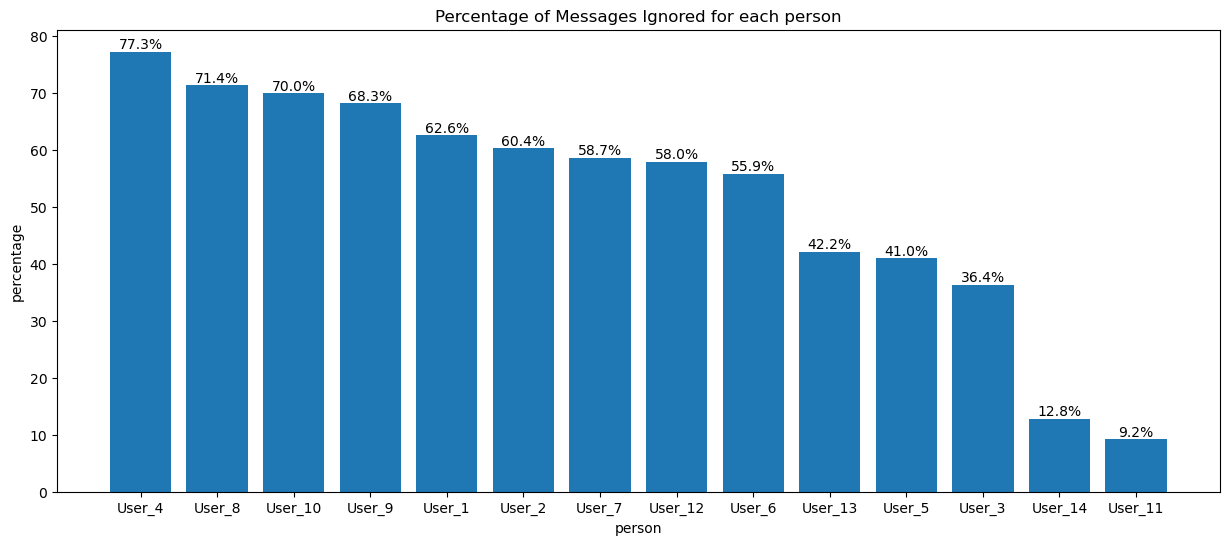

In [18]:
plt.figure(figsize=(15,6))
ign = plt.bar(x=replied_per_person.index, height='ignored', data=replied_per_person)
plt.bar_label(
    ign,
    labels=[f'{v:.1f}%' for v in replied_per_person['ignored']]
)
plt.xlabel('person')
plt.ylabel('percentage')
plt.title('Percentage of Messages Ignored for each person')
plt.show()

In [19]:
replyed_messages = messages[~messages['person_replied'].isna()]

In [20]:
trial = pd.DataFrame(replyed_messages.groupby(by=['person', 'person_replied']).agg(count=('person_replied','count')))